## Denoising autoencoder using skip connects between encoder and decoder 

In [1]:
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print('Platform System: ' + platform.system())
print(platform.processor())
print(platform.python_compiler())

x86_64
#1 SMP Wed Dec 19 21:19:13 PST 2018
Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
uname_result(system='Linux', node='14d8f46d1f14', release='4.14.79+', version='#1 SMP Wed Dec 19 21:19:13 PST 2018', machine='x86_64', processor='x86_64')
Platform System: Linux
x86_64
GCC 8.0.1 20180414 (experimental) [trunk revision 259383


In [2]:
import sys
import numpy
import matplotlib
import pandas
import keras

Using TensorFlow backend.


In [3]:
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('keras: {}'.format(keras.__version__))

Python: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
numpy: 1.16.4
matplotlib: 3.0.3
pandas: 0.24.2
keras: 2.2.4


In [4]:
import pickle
import numpy as np

image_size = 96

x_train_pickle = pickle.load(open('/content/drive/My Drive/dog_data/x_train_rgb.pickle',"rb"))
x_valid_pickle = pickle.load(open('/content/drive/My Drive/dog_data/x_valid_rgb.pickle',"rb"))
x_test_pickle = pickle.load(open('/content/drive/My Drive/dog_data/x_test_rgb.pickle', "rb"))

x_test = np.array(x_test_pickle).reshape(-1, image_size, image_size, 3)
x_valid = np.array(x_valid_pickle).reshape(-1, image_size, image_size, 3)
x_train = np.array(x_train_pickle).reshape(-1, image_size, image_size, 3)

x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)


(8409, 96, 96, 3)
(2498, 96, 96, 3)
(68, 96, 96, 3)


In [0]:
import matplotlib as mpl
import pydot
mpl.rcParams['figure.dpi'] = 150

Text(0.5, 1.0, 'Test Data')

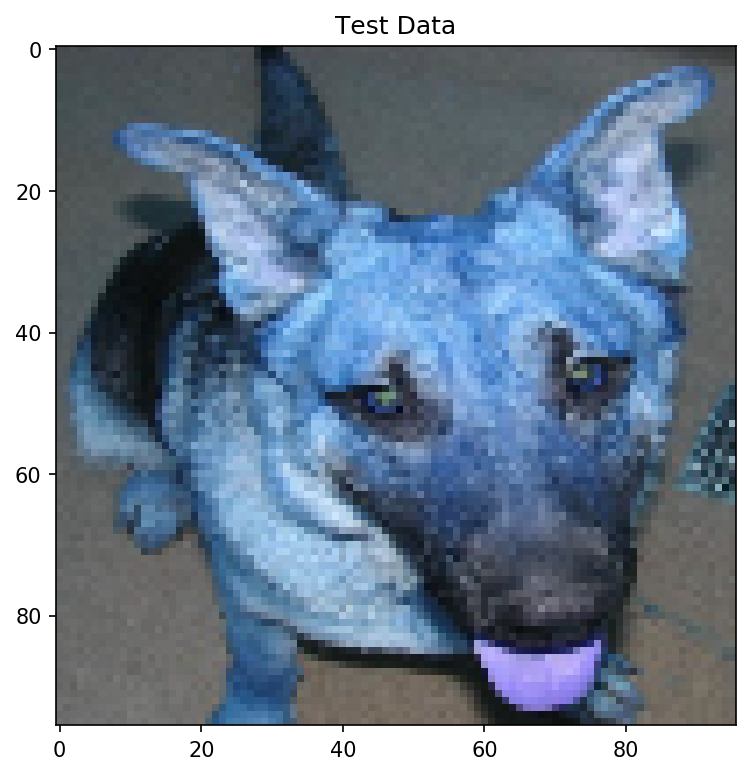

In [6]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

plt.imshow(x_test[1,:,:,:])
plt.title('Test Data')

In [0]:
import numpy as np

x_test = np.array(x_test).reshape(-1, image_size, image_size, 3)
x_valid = np.array(x_valid).reshape(-1, image_size, image_size, 3)
x_train = np.array(x_train).reshape(-1, image_size, image_size, 3)

In [0]:
noise_factor = 0.2 
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = x_train.shape) 
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = x_valid.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = x_test.shape) 

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import sys

start = time.time();

np.random.seed(42)

W0625 03:25:47.609921 139780663519104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Noisy (but still cute) Dog')

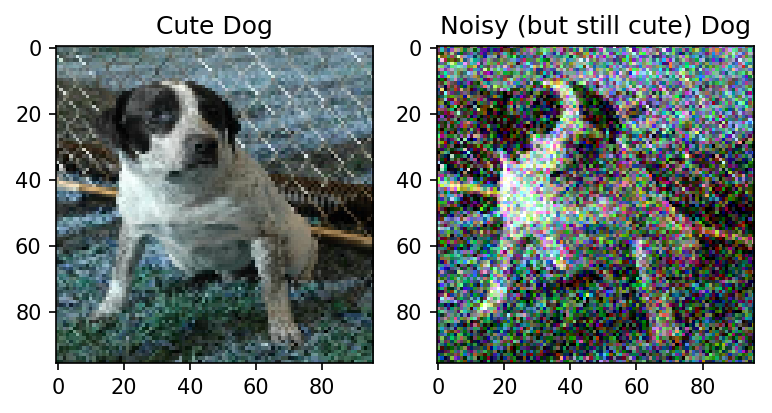

In [10]:
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.title('Cute Dog')
plt.subplot(1,2,2)
plt.imshow(x_train_noisy[0,:,:,:].squeeze())
plt.title('Noisy (but still cute) Dog')

In [81]:
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
latent_dim = 32

from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

input_img = Input(shape=(image_size, image_size, 3),
                  name = 'input')

x = Conv2D(filters = 64,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
           name = 'conv0')(input_img)
x = BatchNormalization()(x)
x  = Activation('tanh')(x)
res0 = x

x = Conv2D(filters = 96,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
           name = 'conv1')(x)
x = BatchNormalization()(x)
x  = Activation('tanh')(x)
res1 = x


x = MaxPooling2D(pool_size = (2, 2),
                 padding='same',
                 name = "pool1")(x)


x = Conv2D(filters = 128,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
          name = 'conv4')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
res4 = x

encoded = MaxPooling2D(pool_size = (2, 2),
                       padding='same',
                      name = 'pool2')(x)

x = Conv2D(64, (3, 3), 
           padding='same')(encoded)


x = UpSampling2D(size = (2, 2))(x)
# x = keras.layers.Add()([res3,x])

x = Conv2DTranspose(filters = 128, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                     
                    padding='same',
                   name = "conv_transpose1")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res4,x])
x = Activation('tanh')(x)


x = UpSampling2D(size = (2, 2))(x)


# x = keras.layers.Add()([res2,x])

x = Conv2DTranspose(filters = 96, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    
                    padding='same',
                   name = "conv_transpose2")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res1,x])
x = Activation('tanh')(x)

x = Conv2DTranspose(filters = 64, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    
                    padding='same',
                   name = "conv_transpose3")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res0,x])
x = Activation('tanh')(x)

decoded = Conv2DTranspose(filters = 3,
                          kernel_size = (3, 3),
                          strides = (1, 1),
                          activation='sigmoid',
                          padding='same',
                         name = "output_conv_transpose")(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(metrics = ['mse'],
                    loss='mse', 
                    optimizer='adadelta')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 96, 96, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 96, 96, 64)   256         conv0[0][0]                      
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 96, 96, 64)   0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv1 (Con

In [82]:
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data= (x_valid_noisy, x_valid),
                epochs=5,
                batch_size=batch_size)

Train on 8409 samples, validate on 2498 samples
Epoch 1/5
8409/8409 [==============================] - 63s 7ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2/5
8409/8409 [==============================] - 50s 6ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 3/5
8409/8409 [==============================] - 50s 6ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 4/5
8409/8409 [==============================] - 50s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 5/5
8409/8409 [==============================] - 50s 6ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0120 - val_mean_squared_error: 0.0120


In [0]:
x_decoded = autoencoder.predict(x_test_noisy)

W0625 03:49:01.796840 139780663519104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


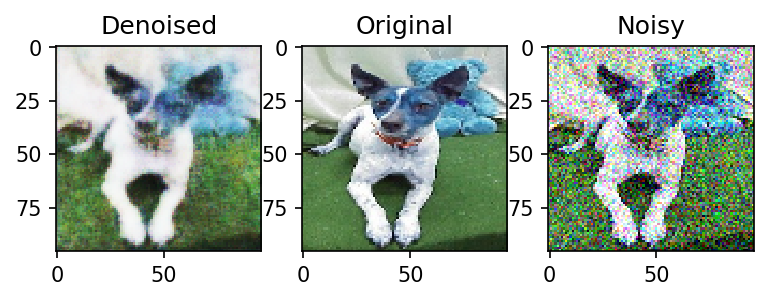

In [84]:
i = 14

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[i].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[i].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_noisy[i].squeeze())

W0625 03:49:02.290030 139780663519104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


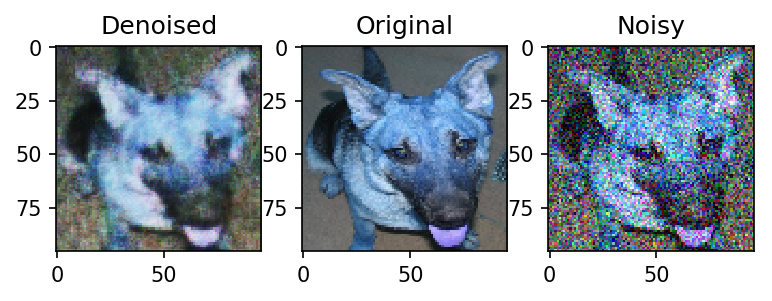

In [85]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[1].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[1].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_noisy[1].squeeze())

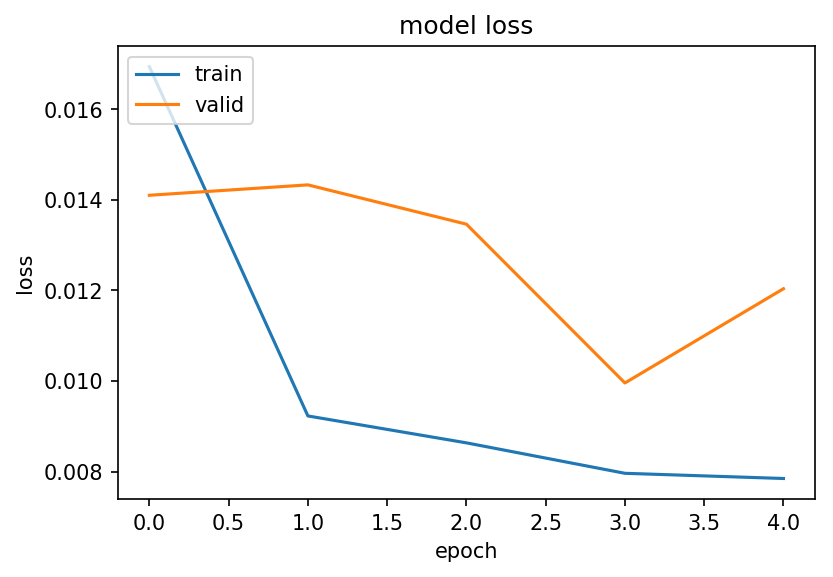

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# 